In [45]:
from mylib.statistic_test import *

code_id = "0840 - Behavioral Trajectory Similarity and Remapping"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

def identify_perfect_lap(trace):
    beg, end = LapSplit(trace, trace['paradigm'])
    route_ids = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)

    D = GetDMatrices(trace['maze_type'], 48)
    dist = D[trace['correct_nodes'].astype(np.int64)-1, 2303]
    old_nodes = spike_nodes_transform(trace['correct_nodes'], 12)

    is_perfect = np.zeros(route_ids.shape[0], np.int64)
    for i in range(route_ids.shape[0]):
        CP = cp.deepcopy(CP_DSP[route_ids[i]])
        
        # Enter Error Track
        if np.isin(old_nodes[beg[i]:end[i]], CP).all() == False:
            continue
        
        # If enter the ending point
        if np.isin(old_nodes[end[i]], CP[-3:]) == False:
            continue
        
        # Return
        dx = np.ediff1d(dist[beg[i]:end[i]])
        # Lowever than 5 for every point
        if np.sum(dx < 5) == dx.shape[0]:
            is_perfect[i] = 1
    
    return is_perfect

"""
for i in range(len(f2)):
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
        
    print(i, f2['MiceID'][i], f2['date'][i], ' session '+str(f2['session'][i]), f2['Trace File'][i])
    trace['is_perfect'] = identify_perfect_lap(trace)
    with open(f2['Trace File'][i], 'wb') as handle:
        pickle.dump(trace, handle)
"""


        E:\Data\FinalResults\Dsp\0840 - Behavioral Trajectory Similarity and Remapping is made up successfully!
0 10209 20230524  session 1 E:\Data\Dsp_maze\10209\20230524\trace.pkl
1 10212 20230524  session 1 E:\Data\Dsp_maze\10212\20230524\trace.pkl
2 10209 20230526  session 1 E:\Data\Dsp_maze\10209\20230526\trace.pkl
3 10212 20230526  session 1 E:\Data\Dsp_maze\10212\20230526\trace.pkl
4 10209 20230528  session 1 E:\Data\Dsp_maze\10209\20230528\trace.pkl
5 10212 20230528  session 1 E:\Data\Dsp_maze\10212\20230528\trace.pkl
6 10209 20230529  session 1 E:\Data\Dsp_maze\10209\20230529\trace.pkl
7 10212 20230529  session 1 E:\Data\Dsp_maze\10212\20230529\trace.pkl
8 10209 20230530  session 1 E:\Data\Dsp_maze\10209\20230530\trace.pkl
9 10212 20230530  session 1 E:\Data\Dsp_maze\10212\20230530\trace.pkl
10 10209 20230601  session 1 E:\Data\Dsp_maze\10209\20230601\trace.pkl
11 10212 20230601  session 1 E:\Data\Dsp_maze\10212\20230601\trace.pkl
12 10209 20230602  session 1 E:\Data\Dsp_maze\

# Computed Shortest Distances Across Behavioral Trajectory

In [24]:
def inter_traj_distances(traj1: np.ndarray, traj2: np.ndarray):
    # Expand and broadcast the arrays to calculate pairwise squared differences
    diff = traj1[:, np.newaxis, :] - traj2[np.newaxis, :, :]
    dist_mat = np.sqrt(np.sum(diff**2, axis=2))
    short_point = np.min(dist_mat, axis=1)
    return np.sum(short_point)
    
if exists(join(figdata, code_id+'.pkl')) == False:
    thres = {10212: 0.114, 10224: 0.0815, 10227: 0.0751, 10232: 0.0956}
    
    if [exists(join(loc, f'{mouse}.pkl')) for mouse in [10212, 10224, 10227, 10232]].count(False) > 0:
        for mouse in [10212, 10224, 10227, 10232]:
            idx = np.where(f2['MiceID'] == mouse)[0]
        
            trajs = []
            map_types = []
            ctrl_types = []
            corr_thre = thres[mouse]
        
            print(f"Mouse {mouse}")
            for i in tqdm(idx):
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
            
                beg, end = LapSplit(trace, trace['paradigm'])
                old_bins = spike_nodes_transform(trace['correct_nodes'], 12)
                route_ids = classify_lap(old_bins, beg)
                for i in np.where((route_ids == 6) | (route_ids == 0) | (route_ids == 3))[0]:
                    if trace['is_perfect'][i] == 1:
                        try:
                            init_p = beg[i] + np.where(np.isin(old_bins[beg[i]:end[i]], [99, 87, 88]))[0][0]
                        except:
                            print(old_bins[beg[i]:end[i]])
                            continue
                        
                        trajs.append(trace['correct_pos'][init_p:end[i], :]/10)
                        map_types.append(1 if trace['lapwise_corr'][i] < corr_thre else 2)
                        if route_ids[i] == 6:
                            ctrl_types.append(1)
                        elif route_ids[i] == 0:
                            ctrl_types.append(2)
                        elif route_ids[i] == 3:
                            ctrl_types.append(3)
                    
            # Calculate the inter-traj distances
            dist_mat = np.full((len(trajs), len(trajs)), np.nan)
            group_mat = np.zeros_like(dist_mat, np.int64)-1
            ctrl_mat = np.zeros_like(dist_mat, np.int64)-1
        
            for i in range(len(trajs)-1):
                for j in range(i+1, len(trajs)):
                    dist_mat[i, j] = inter_traj_distances(trajs[i], trajs[j]) if trajs[i].shape[0] <= trajs[j].shape[0] else inter_traj_distances(trajs[j], trajs[i])
                    dist_mat[j, i] = dist_mat[i, j]
                    if map_types[i] == map_types[j] == 1:
                        group_mat[i, j] = 1
                        group_mat[j, i] = 1
                    elif map_types[i] == map_types[j] == 2:
                        group_mat[i, j] = 2
                        group_mat[j, i] = 2
                    else:
                        group_mat[i, j] = 3
                        group_mat[j, i] = 3
                        
                    if ctrl_types[i] == ctrl_types[j]:
                        ctrl_mat[i, j] = ctrl_types[i]
                        ctrl_mat[j, i] = ctrl_types[i]
                    
                
            with open(join(loc, f"{mouse}.pkl"), 'wb') as handle:
                pickle.dump([dist_mat, group_mat, ctrl_mat], handle)
                
    Data = {
        "MiceID": [],
        "Distance": [],
        "Group": [],
        "Ctrl": []
    }
        
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
            dist_mat, group_mat, ctrl_mat = pickle.load(handle)
                
        mean_mat = (dist_mat + dist_mat.T)/2
        triu_indices = np.triu_indices(dist_mat.shape[0], 1)
        dist, group, ctrl = mean_mat[triu_indices], group_mat[triu_indices], ctrl_mat[triu_indices]
        
        idx = np.where(ctrl != -1)[0]
        Data['MiceID'].append(np.repeat(mouse, len(idx)))
        Data['Distance'].append(dist[idx])
        Data['Group'].append(group[idx])
        Data['Ctrl'].append(ctrl[idx])
            
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
            
    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
            
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+'.xlsx'), index=False)
        
else:
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)

idx = np.where(
    (Data['Ctrl'] == 1) |
    ((Data['Ctrl'] == 2) & (Data['Group'] == 2)) |
    ((Data['Ctrl'] == 3) & (Data['Group'] == 1))
)[0]
Data = SubDict(Data, Data.keys(), idx)
Data['hue'] = np.array([f"{Data['Group'][i]}-{Data['Ctrl'][i]}" for i in range(len(Data['Group']))])


Ttest_indResult(statistic=-18.359571577640995, pvalue=1.0)
  Mean: 56.58464139249622, STD: 11.225783311703953, Max: 103.17863277532386, Min: 36.981540031016294, Median: 54.789735168771486, df: 524
  Mean: 63.40326780669737, STD: 14.436823577682363, Max: 170.48958636545427, Min: 35.27559010937527, Median: 60.57591116776835, df: 1013
  Mean: 61.119252765247474, STD: 11.723588054808506, Max: 149.8741655777125, Min: 34.81489889214254, Median: 59.44861639934523, df: 3492


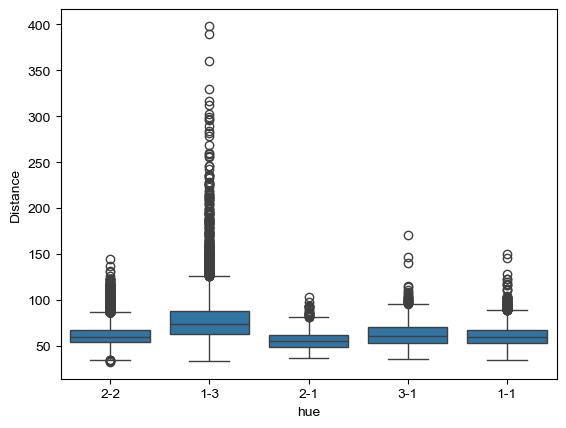

In [43]:
sns.boxplot(
    x = 'hue',
    y = 'Distance',
    data = Data
)
print(ttest_ind(Data['Distance'][Data['hue'] == '3-1'], Data['Distance'][Data['hue'] == '1-3'], alternative="greater"))
print_estimator(Data['Distance'][Data['hue'] == '2-1'])
print_estimator(Data['Distance'][Data['hue'] == '3-1'])
print_estimator(Data['Distance'][Data['hue'] == '1-1'])

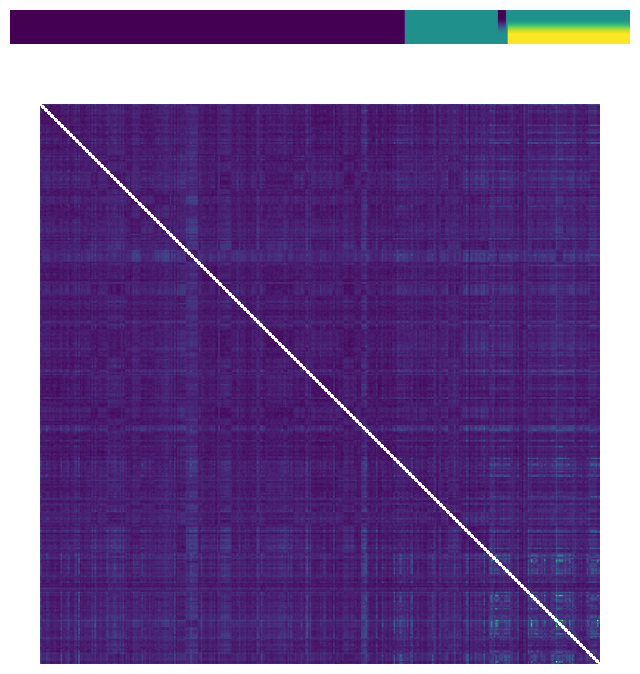

In [ ]:
with open(join(loc, "10232.pkl"), 'rb') as handle:
    dist_mat, group_mat, ctrl_mat = pickle.load(handle)

map_types = np.zeros(dist_mat.shape[0], np.int64)
for i in range(dist_mat.shape[0]):
    map_types[i] = np.unique(group_mat[i, :])[1]
map_types = 3 - map_types

ctrl_types = np.zeros(dist_mat.shape[0], np.int64)
for i in range(dist_mat.shape[0]):
    ctrl_types[i] = np.unique(ctrl_mat[i, :])[1]

idx1 = np.where(ctrl_types == 1)[0]
idx2 = np.where(ctrl_types == 2)[0]

ctrl_types[idx1] = 2
ctrl_types[idx2] = 1

# Sort matrix
sort_idx = np.argsort(map_types)
sort2_idx = np.argsort(ctrl_types[sort_idx])
sort_idx = sort_idx[sort2_idx]

dist_mat = dist_mat[sort_idx, :][:, sort_idx]
map_types = map_types[sort_idx]
ctrl_types = ctrl_types[sort_idx]

labels = np.vstack((map_types, ctrl_types))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (8, 8.5), gridspec_kw=({'height_ratios': [0.5, 8]}))
ax = Clear_Axes(axes[0])
ax.imshow(labels)
ax.set_aspect("auto")
ax = Clear_Axes(axes[1])
im = ax.imshow(dist_mat)
#plt.savefig(join(loc, "temp.png"), dpi = 2400)